### Process_CoreBx_island_v5

Read the interpolated DEMs for the entire island and do volume calcs.
This version was modifed in mid May.

This reads the .nc file created by `CoreBx_island_v5` and is based on Process_CoreBx_multi_v2.

It gets a `v5` because it tries to process the entire big island.


TODO:
* Correct aspect ratio on maps?
* Equal axes for all line plots?
* Add colorbars. Add labels to colorbars
* Add a), b), ...
* Remove titles?
* If the x, y labeling changes in CoreBx_multi, then correct here too.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import xarray as xr
import pandas as pd
# from dask.distributed import LocalCluster
from scipy import interpolate, signal
%matplotlib inline

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']


# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
import pickle
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

tcmap=cmap_ncb
#tcmap=plt.cm.terrain
tcmap.set_bad(color='darkgray')

In [2]:
%run -i CoreBx_funcs

In [3]:
# Dates for DEMs
dates = ([\
         "30 Aug 2019",\
         "13 Sep 2019",\
         "11 Oct 2019",\
         "26 Nov 2019"])

# Offsets for DEM elevation corrections (should not be needed when we get to Andy's data )
# offset = np.array([0., 0., 0., 0.])
offset = np.array([-0.022233, 0.002373, 0.004543, 0.015317])

MHHW = 0.4 #elevation of MHHW per VDATUM

# hole-filling options
holes = (["clip","extend"])
ihole = 1 # pick 1 or 2d

# Make a dict, where analysis region is defined by:
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 

# This block is copied from CoreBx_multi, with addition of xs_end and d_end:
# Not sure value / settings of xs_end and d_end for entire island
#r = {'name':"ncorebx","e0": 378500.,"n0": 3856350.,"xlen": 36000.,"ylen": 1100.,"dxdy": 1.,"theta": 42.,'xs_end':800,'d_end':600}

# This box came from calcs done in CoreBx_island_v5
r = {'name':'ncorebx_v5','e0':378489.45785126585,'n0': 3855740.5011377367,'xlen': 36650.0,'ylen': 1500.0,'dxdy': 1.0,'theta': 42.0}

# initialize maps arrays fo
nmaps = len(dates)
vsum = np.zeros((nmaps))
vsumall = np.zeros((nmaps))
vchange = np.zeros((nmaps-1))
vchangeall = np.zeros((nmaps-1))

statsfn = "island_stats_{}.txt".format(holes[ihole])
sfile = open(statsfn, "w")

print("",file=sfile)
print('Region: ',r['name'],file=sfile)

# read in the multi-map .nc file
fn = r['name']+'.nc'
dsa = xr.open_dataset(fn)
dsaa = np.squeeze(dsa.to_array())
nmaps,ncross,nalong=np.shape(dsaa)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

# Correct for uniform offsets
for i in range(0,nmaps):
    dsaa[i,:,:] = dsaa[i,:,:] + offset[i] 

# NaNs below -1m
dsaa = dsaa.where(dsaa>=-1.0)
map_stats(dsaa,sfile)

# read in the fill map
fnf = r['name']+'_Sep_fill.nc'                
dsf = xr.open_dataset(fnf)
dsfa = np.squeeze(dsf.to_array())
ncrossf,nalongf=np.shape(dsfa)
print('ncrossf, nalongf: ',ncrossf,nalongf)

# correct for August offset
dsfa = dsfa+offset[0]

# NaNs below -1 m
dsfa = dsfa.where(dsfa>=-1.) 
map_stats2d(dsfa,sfile)

nmaps, ncross, nalong:  4 1500 36650
ncrossf, nalongf:  1500 36650


(1.1548327876530733, 1.2136646917950367)

In [86]:
%run -i CoreBx_funcs
# Read in the digitized profile of dune crest profile
df=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line_2.csv",header = None)
df

,0,1
0,380166.478,3858154.267
1,380186.114,3858157.774
2,380199.439,3858163.384
3,380207.153,3858173.202
4,380245.024,3858341.515
...,...,...
1250,405094.566,3880231.042
1251,405118.235,3880283.113
1252,405118.235,3880330.451
1253,405100.878,3880385.679


<Figure size 432x288 with 0 Axes>

In [87]:
xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values

#xdune,ydune=UTM2rot(xUTM,yUTM,r)
xdune,ydune=UTM2Island(xUTM,yUTM)
y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(y)

n      = 36651.000
nnan   = 3177.000
mean   = 245.375
std    = 108.560
min    = 0.000
max    = 584.452
d5     = 60.133
d25    = 184.300
d50    = 251.249
d75    = 310.490
d95    = 421.010


CoreBx_funcs.py:13: RuntimeWarning: invalid value encountered in less
  stdx = np.nanstd(x)


Text(0, 0.5, 'Cross-shore distance (m)')

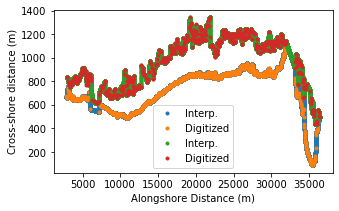

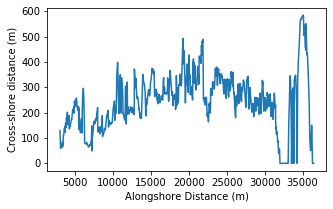

In [89]:
# read in the digitized profile for the back side at the ~1.25-m contour interval
dfb=pd.read_csv("C:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\back_125_2.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values
# rotate to alongshore/cross-shore coordinates
#xback,yback=UTM2rot(xUTMb,yUTMb,r)
xback,yback=UTM2Island(xUTMb,yUTMb)
# interplote
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
ybacki = fb(y)

# ensure back >= dune
ybacki[ybacki<ydunei]=ydunei[ybacki<ydunei]
iswide = ybacki-ydunei

stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(y,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(y,ybacki,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(y,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

0 0.0 671.632101456169
dx:  1.0
nmaps, length profiles:  4 1500
Shape of dist:  (1500,)
Shape of profs:  (4, 1500)
Shape of pfill:  (1500,)
0 736 [       nan        nan        nan 1.56797232 1.71330183 1.85475437]
1 741 [       nan        nan        nan 1.36997245 1.34238068 1.35553745]
2 739 [       nan        nan        nan 1.45441605 1.52991621 1.61290753]
3 733 [       nan        nan        nan 0.74862873 0.80478935 0.8051404 ]
extend
Slope is: 0.1429
Slope is: 0.0220
Slope is: 0.1067
Slope is: 0.0021
0 736 [-0.00352455  0.1393349   0.28219434  0.42505379  0.56791324  0.71077269]
1 741 [0.34911715 0.37113295 0.39314875 0.41516455 0.43718034 0.45919614]
2 739 [0.11614666 0.22287466 0.32960266 0.43633066 0.54305866 0.64978666]
3 733 [0.         0.         0.         0.74862873 0.80478935 0.8051404 ]
iisl, disl 663 1399.0
iisl, disl 658 1399.0
iisl, disl 660 1399.0
iisl, disl 666 1399.0
i, zmax, dmax 0 5.664719981871675 1056.0
i, zmax, dmax 1 5.298927863487656 1056.0
i, zmax, dmax 2 5

CoreBx_funcs.py:217: RuntimeWarning: invalid value encountered in greater_equal
  ixd[i] = int(np.argwhere((profs[i,:]>=datum))[0])


Wall time: 1.01 s


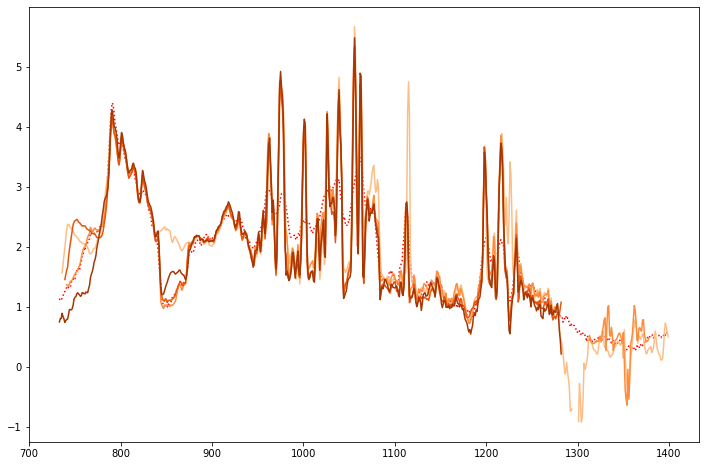

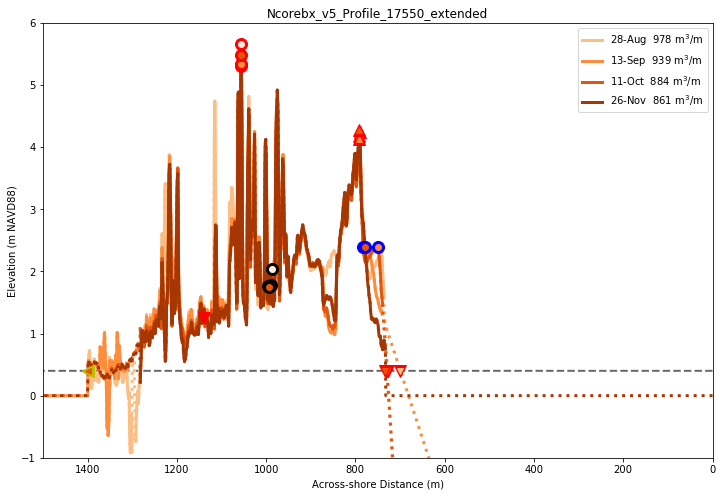

In [7]:
%%time

# single profile code here for testing
dist = np.arange(0,ncross)
iprof = 17550
#iprof = 35999
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

nprofs = 1

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe = v.copy()
width_island = v.copy()
width_platform = v.copy()

maxdist = 100.
proff = np.squeeze(np.array((dsaa[:,:,iprof])))
pfill = np.squeeze(np.array((dsfa[:,iprof])))

title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
i=0
print(i,y[i],ydune[i])


v[:,i], vp[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe[:,i],\
width_island[:,i], width_platform[:,i] = \
      pvol(dist,proff,pfill,ydunei[iprof],ybacki[iprof],\
      title_str,pnames,imethod='extend',\
      datum=datum,\
      maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
      iverbose=True,iplot=True,iprint=True)

In [8]:
%%time
%run -i CoreBx_funcs
# process all of them
dist = np.arange(0,ncross)
iprof = 6500;
title_str = 'test pvol'
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']
datum = 0.4 

profile_list = range(0,nalong,1)
nprofs = len(profile_list)
print(nprofs, profile_list)

# allocate arrays for profile info
y = np.zeros(nprofs)
v = np.zeros((nmaps,nprofs))
vp = np.zeros((nmaps,nprofs))
cxcy = np.zeros((nmaps,nprofs,2))
zmax = v.copy()
dmax = v.copy()
zmax = v.copy()
dmax = v.copy()
zcrest = v.copy()
dcrest = v.copy()
zcrest0 = v.copy()
dtoe = v.copy()
width_island = v.copy()
width_platform = v.copy()

maxdist = 100.
for i, iprof in enumerate(profile_list):
    proff = np.squeeze(np.array((dsaa[:,:,iprof])))
    pfill = np.squeeze(np.array((dsfa[:,iprof])))

    title_str = '{0}_Profile_{1}'.format(r['name'].capitalize(),iprof)
    y[i] = iprof
    #print(iprof,y[iprof],ydune[iprof])
    # dunes are farther back in NE portion
    if y[i] >=25000:
        maxdist = 200.
    v[:,i], vp[:,i], cxcy[:,i], zmax[:,i], dmax[:,i], zcrest[:,i], dcrest[:,i], zcrest0[:,i], dtoe[:,i],\
    width_island[:,i], width_platform[:,i] = \
          pvol(dist,proff,pfill,ydunei[iprof],ybacki[iprof],\
          title_str,pnames,imethod='extend',\
          datum=datum,\
          maxdist=maxdist,ztoe=2.4,zowp=1.25,nsmooth=51,\
          iverbose=False,iplot=False,iprint=False)


36650 range(0, 36650)


CoreBx_funcs.py:217: RuntimeWarning: invalid value encountered in greater_equal
  ixd[i] = int(np.argwhere((profs[i,:]>=datum))[0])
CoreBx_funcs.py:466: RuntimeWarning: Mean of empty slice
  cz = np.nanmean(z)
CoreBx_funcs.py:467: RuntimeWarning: invalid value encountered in double_scalars
  cx = np.nansum(z*x)/np.nansum(z)


Wall time: 1min 21s


<Figure size 432x288 with 0 Axes>

In [9]:
# volumme calcs
vp_tot = np.nansum(vp,1)
print(vp_tot)
ap_tot = np.nansum(width_platform,1)
print(ap_tot)
print(vp_tot/vp_tot[0])

[17583038.42011517 14727060.27768638 14418849.73472998 14888310.14949204]
[11900843.64135342 11754150.64135342 11732525.64135342 11350663.64135342]
[1.         0.83757198 0.82004312 0.84674274]


In [10]:
# Uncertainty on volume calcs
import numpy as np
sigma_rs = np.ones_like(vp_tot)*np.nan
sigma_sc = sigma_rs.copy()
sigma_rmsd = np.sqrt(2.*0.2**2)
print('sigma_rmsd:',sigma_rmsd)

L2 = 1. # 1-m grid
for imap in range((nmaps)):

    # Uncorrelated random error
    n = ap_tot[imap] # approximate area
    print('area:',n)
    sigma_rs[imap] = sigma_rmsd/np.sqrt(n)

    # Spatially correlated data (max values)
    sill=np.sqrt(0.03)
    sigma_sill= np.sqrt( sill )
    r = 360.
    sigma_sc[imap] = (sigma_sill/np.sqrt(n)) * np.sqrt((np.pi*r**2)/(5.*L2))
    Asc = np.pi*r**2/(5.*n*L2)
    print('Asc: ',Asc)
    
# Systematic error
sigma_sys = 0.07

# total error
sigma_tot = np.sqrt( sigma_rs**2. + sigma_sc**2. + sigma_sys**2.)

for i in range(nmaps-1):
    ss=stat_summary(width_platform[i,:],iprint=False)
    print('Platform width d50: {:.3f}'.format(ss['d50']))

    print('sigma_rs:           {:.6f}'.format(sigma_rs[i]))
    print('sigma_sc:           {:.6f}'.format(sigma_sc[i]))
    print('sigma_tot:          {:.6f}'.format(sigma_tot[i]))

print('ap_tot: ',ap_tot)
print('vp_tot: ',vp_tot)
print('avg. elevation: ',vp_tot/ap_tot)
vdiff = np.diff(vp_tot,1,0)
print('diff(vp_tot):',vdiff)
print('diff as fraction of initial volume: ',vdiff/ap_tot[0])
err = ap_tot*sigma_tot
print('err volume',err)
print('err pct of volume initial volume: ',err/np.mean(np.diff(vp_tot,1,0)))
print('err (frac of volume change):',err/vp_tot[0])
print('avg. elevation change: ',vdiff/np.mean(ap_tot))

sigma_rmsd: 0.28284271247461906
area: 11900843.641353423
Asc:  0.0068423789132134845
area: 11754150.641353423
Asc:  0.006927772500597391
area: 11732525.641353423
Asc:  0.006940541539839665
area: 11350663.641353423
Asc:  0.007174037056685959
Platform width d50: 351.747
sigma_rs:           0.000082
sigma_sc:           0.034426
sigma_tot:          0.078007
Platform width d50: 338.874
sigma_rs:           0.000082
sigma_sc:           0.034640
sigma_tot:          0.078102
Platform width d50: 336.598
sigma_rs:           0.000083
sigma_sc:           0.034672
sigma_tot:          0.078116
ap_tot:  [11900843.64135342 11754150.64135342 11732525.64135342 11350663.64135342]
vp_tot:  [17583038.42011517 14727060.27768638 14418849.73472998 14888310.14949204]
avg. elevation:  [1.47746151 1.25292424 1.22896384 1.31166869]
diff(vp_tot): [-2855978.14242879  -308210.5429564    469460.41476206]
diff as fraction of initial volume:  [-0.23998115 -0.02589821  0.03944766]
err volume [928352.88317787 918023.41064

### Summary in words
* Initial island volume was 17.6 million m3, initial area was about 12.5 m2, so inital avg. elevation was 1.47 m
* Volume changes were -2.9 million, -0.31 m, +0.47 million m3
* Uncertainties around these are about 5%
* These changes represent fractional changes of -0.25 -0.02  0.04 of the initial volume
* Average elevation change was -0.24 -0.03  0.04 m


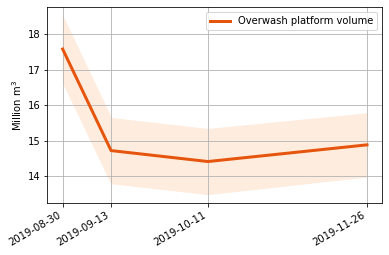

In [11]:
# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
#plt.plot(dt,vsumall/1e6,label="Entire island")
ax.fill_between(dt, (vp_tot+err)/1e6, (vp_tot-err)/1e6,color=cols[0] )
plt.plot(dt,vp_tot/1e6,label="Overwash platform volume",c=cols[3],linewidth=3)
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
#plt.title('Island Volume')
fig_name = 'island_volume.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_volume.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [12]:
# average elevation (alongshore)
melev = vp / width_platform
print('Shape of alongshore mean elevation: ',np.shape(melev))
# average elevation difference
melev_diff = np.diff(melev,1,0)
print('Shape of elevation difference: ',np.shape(melev_diff))
for i in range(nmaps-1):
    sstat=stat_summary(melev_diff[i,:],iprint=False)
    print('d50: ',sstat['d50'],'mean',sstat['mean'])

Shape of alongshore mean elevation:  (4, 36650)
Shape of elevation difference:  (3, 36650)
d50:  -0.0861194110822881 mean -0.2055891634835333
d50:  -0.002483891075446887 mean 0.0018199857641776774
d50:  0.013218457497863462 mean 0.01940632075411205


### Island-wide max. elevation, volume, and average elevation

(4, 36650)


C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\lib\nanfunctions.py:1667: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
CoreBx_funcs.py:14: RuntimeWarning: invalid value encountered in less_equal
  minx = np.nanmin(x)
CoreBx_funcs.py:441: RuntimeWarning: Mean of empty slice
  sy[nclip:-nclip] = np.nanmean(y2D,1)


(36650,) (36650,)


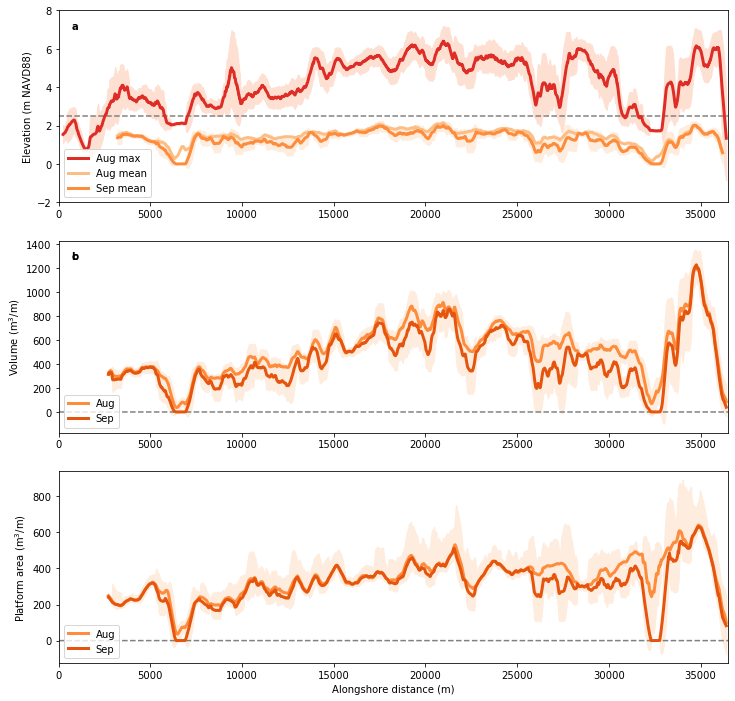

In [13]:
melev0s = running_mean(melev[0,:],501)
melev1s = running_mean(melev[1,:],501)

print(np.shape(melev))
pelev = vp / width_platform
pelev0s = running_mean(pelev[0,:],501)
pelev1s = running_mean(pelev[1,:],501)
pelev1sd = running_stddev(pelev[1,:],501)
pelev_diff = running_mean(pelev[1,:]-pelev[1,:],501)

# island width is wrong in places with no island volume
# TODO: maybe fix this in profile calcs?
width_platform0=width_platform.copy()
width_platform0[vp<=10.]=0.

# average volume
vpmean = np.zeros_like(vp)
vpstd = vpmean.copy()
apmean = vpmean.copy()
apstd = vpmean.copy()

# smooth volumes and widths
for i in range(0,4):
    vpmean[i,:] = running_nanmean(vp[i,:],501)
    vpstd[i,:] = running_stddev(vp[i,:],501)
    apmean[i,:] = running_nanmean(width_platform0[i,:],501)
    apstd[i,:] = running_stddev(width_platform0[i,:],501)

# smooth max elevations in August
x = zmax[0,:]
xs = running_nanmean(x,501)
xstd = running_stddev(x,501)
print(np.shape(x),np.shape(xs))

#vp_err = np.sqrt( vpstd**2 + (width_platform*np.tile(sigma_tot,[nalong,1]).T)**2 ) 

plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,xs,'-',linewidth=3,c=red3[2],label='Aug max')
ax1.fill_between(y,xs-xstd,xs+xstd,color=red3[0])
plt.plot(y,pelev0s,linewidth=3,c=cols[1],label='Aug mean')
plt.plot(y,pelev1s,linewidth=3,c=cols[2],label='Sep mean')
ax1.fill_between(y,pelev1s-pelev1sd,pelev1s+pelev1sd,color=cols[0])
plt.ylim((-2,8))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower left')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,36500))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,vpmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,vpmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax2.fill_between(y,vpmean[0,:]-vpstd[0,:],vpmean[0,:]+vpstd[0,:],color=cols[0])
ax2.fill_between(y,vpmean[1,:]-vpstd[1,:],vpmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
#plt.xlabel('Alongshore distance (m)')

ax3=plt.subplot(313)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
plt.plot(y,apmean[0,:],linewidth=3,c=cols[2],label='Aug')
plt.plot(y,apmean[1,:],linewidth=3,c=cols[3],label='Sep')
ax3.fill_between(y,apmean[0,:]-apstd[0,:],apmean[0,:]+apstd[0,:],color=cols[0])
ax3.fill_between(y,apmean[1,:]-apstd[1,:],apmean[1,:]+vpstd[1,:],color=cols[0])
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Platform area (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'island_crest_vol_area.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'island_crest_vol_area.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Island-wide dune crest elevations

`zcrest0` is the elevation of the dune crest in August, and the elevations of the same location in subsequent years

* Smooth the curves
* plot dune crest elevations for Aug, Sep, and Nov
* plot dune crest changes


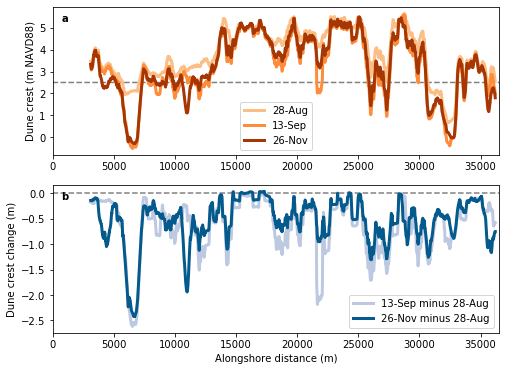

In [14]:
x0s = running_mean(zcrest0[0,:],501)
x1s = running_mean(zcrest0[1,:],501)
x2s = running_mean(zcrest0[2,:],501)
x3s = running_mean(zcrest0[3,:],501)


plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*2.5,'--',c='gray')
plt.plot(y,x0s,'-',linewidth=3,c=cols[1],label=pnames[0])
plt.plot(y,x1s,'-',linewidth=3,c=cols[2],label=pnames[1])
#plt.plot(y,x2s,'-',linewidth=3,c=cols[3],label=pnames[2])
plt.plot(y,x3s,'-',linewidth=3,c=cols[4],label=pnames[3])
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.ylabel('Dune crest (m NAVD88)')
plt.legend()
plt.xlim((0,36500))

xds0 = running_mean( zcrest0[1,:]-zcrest0[0,:], 501)
xds1 = running_mean( zcrest0[2,:]-zcrest0[0,:], 501)
xds2 = running_mean( zcrest0[3,:]-zcrest0[0,:], 501)

ax2=plt.subplot(212)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')

plt.plot(y,xds0,'-',linewidth=3,c=blue5[2],label=pnames[1]+' minus '+pnames[0])
#plt.plot(y,xds1,'-',linewidth=3,c=blue5[3],label=pnames[2]+' minus '+pnames[0])
plt.plot(y,xds2,'-',linewidth=3,c=blue5[4],label=pnames[3]+' minus '+pnames[0])
plt.legend()
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
plt.ylabel('Dune crest change (m)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

fig_name = 'dune_crest_diff.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'dune_crest_diff.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

n      = 36650.000
nnan   = 3065.000
mean   = -0.530
std    = 1.145
min    = -34.351
max    = 2.241
d5     = -2.528
d25    = -0.373
d50    = -0.086
d75    = -0.034
d95    = 0.033
[-2.75 -2.5  -2.25 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.  ]


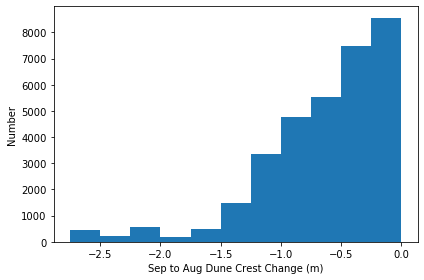

<Figure size 432x288 with 0 Axes>

In [99]:
stat_summary(zcrest[1,:]-zcrest[0,:],iprint=True)
num_bins = 10
bins = np.arange(-2.75,.25,.25)
print(bins)
fig, ax = plt.subplots()

histogram of the data
n, bins, patches = ax.hist(xds0, bins)

ax.set_xlabel('Sep to Aug Dune Crest Change (m)')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('crest_change_histogram.png',bbox_inches='tight', format='png', dpi = 200)

13
Segments: 18000


Text(0, 0.5, 'Dune toe movement (m)')

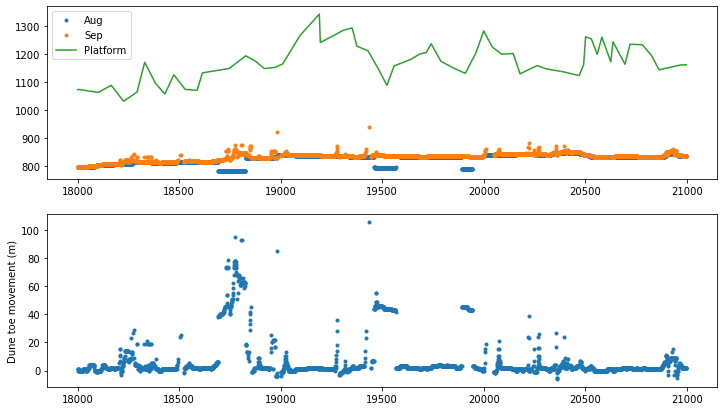

In [15]:
# analyze island segments
sl = 3000
segs = np.arange(0,nalong,sl)
sn = 6
ss = segs[sn] 
se = ss+sl
print(len(segs))
print("Segments:",ss)

dtoe_s0 = signal.medfilt(dtoe[0,:], kernel_size=101)
dtoe_s1 = signal.medfilt(dtoe[1,:], kernel_size=101)
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(y[ss:se],dtoe_s0[ss:se],'.',label='Aug')
plt.plot(y[ss:se],dtoe_s1[ss:se],'.',label='Sep')
plt.plot(y[ss:se],ybacki[ss:se],label='Platform')
plt.legend()

ax2=plt.subplot(212)
dtoe_diff = dtoe_s1[ss:se]-dtoe_s0[ss:se]
plt.plot(y[ss:se],dtoe_diff,'.')
plt.ylabel('Dune toe movement (m)')

# for sn, seg in enumerate(segs):
#     ss = seg
#     se = ss+sl
#     plt.figure(figsize=(12,7))
#     ax1=plt.subplot(211)
#     plt.plot(y[ss:se],dtoe_s0[ss:se],'.')
#     plt.plot(y[ss:se],dtoe_s1[ss:se],'.')
#     plt.plot(y[ss:se],dowp[0,ss:se])

#     ax2=plt.subplot(212)
#     dtoe_diff = dtoe_s0[ss:se]-dtoe_s1[ss:se]
#     plt.plot(y[ss:se],dtoe_diff,'.')


36650


CoreBx_funcs.py:441: RuntimeWarning: Mean of empty slice
  sy[nclip:-nclip] = np.nanmean(y2D,1)
CoreBx_funcs.py:22: RuntimeWarning: invalid value encountered in greater_equal
  meanx = np.NaN


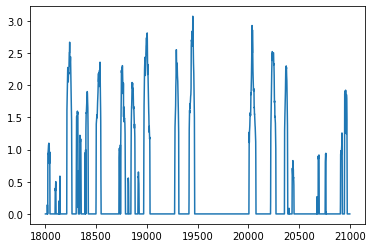

In [16]:
# experiment with various smoothers
if False:
    # smooth first, then difference w/ median filter
    zmax_s0 = signal.medfilt(zmax[0,:], kernel_size=11)
    zmax_s1 = signal.medfilt(zmap0[1,:], kernel_size=11)
    zdiff = zmax_s1-zmax_s0
    zdiff[zdiff>=-0.5]=0.
    
if False:
    # difference first, then smooth
    zmax_0 = zmax[0,:]
    zmax_1 = zmap0[1,:]
    zdiff = zmax_1-zmax_0
    zdiff[zdiff>=-0.5]=0.
    
if True:
    npts = 5
    chdiff = running_nanmean(zcrest0[1,:]-zcrest0[0,:],npts)

cthresh=2.5
chSep = zcrest0[1,:].copy()
chSep[chSep>=cthresh]=cthresh
chSep = chSep-cthresh
chSep[ ~np.isfinite(chSep)] = 0.
plt.plot(y[ss:se],-chSep[ss:se])
print(np.sum(np.isfinite(chSep)))
#plt.plot(y[ss:se],zmax_s0[ss:se])

In [151]:
%run -i CoreBx_funcs
vthresh=0.25 # threshold for minimum channel depth
nc, channel_ctr, channel_area, channel_width, channel_max_depth, channel_avg_depth = analyze_channels(y,-chSep,vthresh=vthresh)
print('September:')
print('Chanel widths:')
cw0 = stat_summary(channel_width,iprint=True)
print('Channel areas:')
ca0 = stat_summary(channel_area,iprint=True)
print('Width: N: {} Mean: {} Min: {} Max: {}'.format(cw0['n'],cw0['mean'],cw0['min'],cw0['max']))
print('Area:  N: {} Mean: {} Min: {} Max: {}'.format(cw0['n'],ca0['mean'],ca0['min'],ca0['max']))

Total channel area m^2/m: 0.56
September:
Chanel widths:
  n, nnan:  297 0
  mean, std, min, max   : 36.000 108.580 1.000 1314.000
  d5, d25, d50, d75, d95: 1.000 3.000 9.000 34.000 108.200
Channel areas:
  n, nnan:  297 0
  mean, std, min, max   : 69.311 277.792 0.251 3494.452
  d5, d25, d50, d75, d95: 0.283 1.518 6.851 52.947 234.954
Width: N: 297 Mean: 36.0 Min: 1.0 Max: 1314.0
Area:  N: 297 Mean: 69.31115354848413 Min: 0.2508475380016777 Max: 3494.452489711347


(1, 162)


Text(0.02, 0.92, 'b')

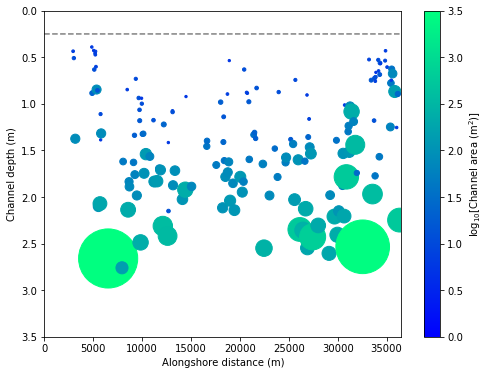

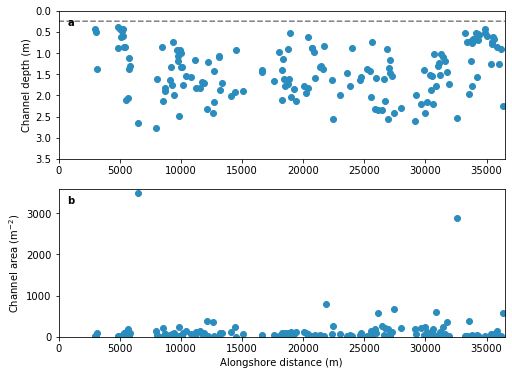

In [100]:
ia = np.where(channel_area>=5.)
print(np.shape(ia))
s = np.array(channel_area[ia])
col = np.array(channel_avg_depth[ia])

plt.figure(figsize=(8,6))
ax1=plt.subplot(111)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.scatter(channel_ctr[ia],channel_avg_depth[ia],s,np.log10(s),cmap=plt.cm.winter)
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.clim((0,3.5))
cbar=plt.colorbar()
cbar.ax.set_ylabel('log$_{10}$[Channel area (m$^2$)]')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.savefig('channel_depth_bubbles.png',bbox_inches='tight', format='png', dpi = 200)

plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.plot(channel_ctr[ia],channel_avg_depth[ia],'.',markersize=12,color=blue5[3])
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')

ax2=plt.subplot(212)
plt.plot(channel_ctr[ia],channel_area[ia],'.',markersize=12,color=blue5[3])
plt.ylim((0,3600))
plt.ylabel('Channel area (m$^{-2}$)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')


(array([], dtype=int64),)
1.452963206621871
[    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000. 36000.]
  n, nnan:  162 0
  mean, std, min, max   : 1.321 0.704 0.372 6.443
  d5, d25, d50, d75, d95: 0.487 0.776 1.255 1.711 2.363


CoreBx_funcs.py:17: RuntimeWarning: Mean of empty slice.
  d50 = np.nanpercentile(x,50.)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
CoreBx_funcs.py:24: RuntimeWarning: Mean of empty slice.
  minx = np.NaN


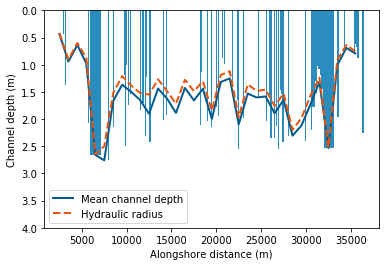

In [171]:
# remove one weird point - this might be the channel that connects to the back
ibad = np.where(channel_avg_depth>=3)
print(ibad)
print(channel_avg_depth[153])
channel_avg_depth[153]=channel_avg_depth[ia].mean()
channel_area[153]=channel_area[ia].mean()
channel_width[153]=channel_area[153]/channel_avg_depth[153]


binw = 1000.
bins = np.arange(0.,36001.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = channel_avg_depth[ia]
digitized = np.digitize(ychan, bins)
bin_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std = [data[digitized == i].std() for i in range(1, len(bins))]

# hydraulic radius
Rh = channel_area/(2.*channel_avg_depth+channel_width)
stat_summary(hradius[ia],iprint=True)
data= Rh[ia]
Rh_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
Rh_std = [data[digitized == i].std() for i in range(1, len(bins))]


plt.bar(channel_ctr[ia],channel_avg_depth[ia],width=channel_width[ia],color=blue5[3])
plt.plot(bin_ctr,bin_mean,'-',color=blue5[4],linewidth=2,label='Mean channel depth')
plt.plot(bin_ctr,Rh_mean,'--',color=cols[3],linewidth=2,label='Hydraulic radius')
plt.ylim((4,0))
plt.xlabel('Alongshore distance (m)')
plt.ylabel('Channel depth (m)')
plt.legend()
plt.savefig('channel_depth_bars.png',bbox_inches='tight', format='png', dpi = 200)

Channel area (m2):
  n, nnan:  162 0
  mean, std, min, max   : 121.666 362.934 5.300 3494.452
  d5, d25, d50, d75, d95: 6.247 12.054 43.494 106.350 359.547


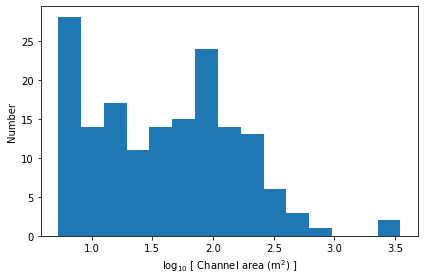

<Figure size 432x288 with 0 Axes>

In [257]:
print('Channel area (m2):')
stat_summary(channel_area[ia],iprint=True)
num_bins = 15
#bins = np.arange(-2.75,.25,.25)
#print(bins)
fig, ax = plt.subplots()

n, bins, patches = ax.hist(np.log10(channel_area[ia]), num_bins)

ax.set_xlabel('log$_{10}$ [ Channel area (m$^{2}$) ]')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('channel_area_histogram.png',bbox_inches='tight', format='png', dpi = 200)

### Estimate flow velocity and total discharge

https://en.wikipedia.org/wiki/Manning_formula

http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm

In [256]:
### Estimate flow velocity using open-channel flow formula

depth=channel_avg_depth[ia]

mann=.025
mann_rough = 0.03
mann_smooth = 0.02
Slope = 1./300.
konv=1.
rhow = 1027.
rhos = 2650.
d50 = 0.43e-3 # Ruggerio, S. Core Banks
d90 = 1.e-3
# print("Base case")

# d50 = 0.25e-3 # Ruggerio, S. Core Banks
# d90 = 0.34e-3
# print("Fine Sediment case")

# Slope = 1./400.
# print("Low slope case")

# Slope = 1./200.
# print("High slope case")

#mann = 0.02
# print("Smooth n case")

# mann = 0.03
# print("Rough n case")

print("Mannings n {:.3f}, slope {:.4f}, d50 (mm) {:.3f}, d90 (mm) {}".\
     format(mann, Slope, d50*1000, d90*1000))
s = rhos/rhow
nu = 1.36e-6
print('s: ',s)
g = 9.81
Dstar = (g*(s-1)/nu**2)**(1./3.)*d50 # Soulsby eqn 99
ws = (nu/d50)*(np.sqrt(10.36**2+1.049*Dstar**3)-10.36) # Soulsby eqn 102
wstar = ws/((g*(s-1)/nu**2)**(1./3.))
print('Dstar:',Dstar,'ws:',ws,'wstar: ',wstar)

theta_cr = (0.3/(1.+1.2*dstar))+0.055*(1.-np.exp(-0.020*dstar)) # Soulsby eqn 77
tauc = theta_cr*(g*rhow*(s-1)*d50)
print('Tauc =',tauc)

# fric = 0.04 # Fig. 3.3 in Dyer - not used
# Cdf = fric/8.
Cdn =   g*mann**2/(depth**(1./3.))

print("Cdn")
stat_summary(Cdn,iprint=True)
Vel   = (konv/mann)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Vello = (konv/mann_rough)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Velhi = (konv/mann_smooth)*Rh[ia]**(2./3.)*np.sqrt(Slope)

Froude = Vel/np.sqrt(g*depth)
tau0   = Cdn*rhow*Vel**2.


print("Froude from Manning")
stat_summary(Froude,iprint=True)
print("Velocity from Manning")
stat_summary(Vel,iprint=True)
print("Tau0 from Manning")
stat_summary(tau0,iprint=True)

### Estimate bed stress from bottom stress
# These give similar, but slightly higher numbers
# taub = rhow*g*depth*Slope[1]
# Ubar = np.sqrt(taub/(rhow*Cdn))
# print('Ubar from slope')
# stat_summary(Ubar,iprint=True)
# print('Taub from slope')
# stat_summary(taub,iprint=True)

# Van Rijn (Eqn 133)
Ucr = 0.19*d50**0.1*np.log10(4.*depth/d90)
if d50>0.5e-3:
    Ucr = 8.5*d50**0.6*np.log10(4.*depth/d90)
Ubar = Vel
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvr = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvr = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Vello
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrlo = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrhi = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Velhi
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrlo = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrhi = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

print("Bedload:")
stat_summary(qbvr,iprint=True)
print("Suspended:")
stat_summary(qsvr,iprint=True)
print("Total:")
stat_summary(qbvr+qsvr,iprint=True)

q = Vel*channel_area[ia]
print("Discharge (m3/s):")
stat_summary(q,iprint=True)

ssc = rhos*qsvr/q
print("SSC (kg/m3):")
stat_summary(ssc,iprint=True)

qlo = Vello*channel_area[ia]
qhi = Velhi*channel_area[ia]
print('Discharge (m3/s): {:.0f} ({:.0f} to {:.0f})'.format(q.sum(), qlo.sum(), qhi.sum()))
qt = qbvr+qsvr
tot_flux = qt*3600*channel_width[ia]
print('Total flux:')
stat_summary(tot_flux,iprint=True)
print('Total flux over one hour: ',tot_flux.sum(),'Accounting for porosity = 0.35: ',tot_flux.sum()/(1.-0.35))

Mannings n 0.025, slope 0.0033, d50 (mm) 0.430, d90 (mm) 1.0
s:  2.5803310613437196
Dstar: 8.734704380597039 ws: 0.05704776349367495 wstar:  2.8083993725959964e-06
Tauc = 0.3789729666338344
Cdn
  n, nnan:  162 0
  mean, std, min, max   : 0.006 0.001 0.004 0.008
  d5, d25, d50, d75, d95: 0.005 0.005 0.005 0.006 0.008
Froude from Manning
  n, nnan:  162 0
  mean, std, min, max   : 0.721 0.072 0.547 0.866
  d5, d25, d50, d75, d95: 0.619 0.660 0.734 0.776 0.830
Velocity from Manning
  n, nnan:  162 0
  mean, std, min, max   : 2.673 0.823 1.195 4.421
  d5, d25, d50, d75, d95: 1.430 1.950 2.687 3.283 4.069
Tau0 from Manning
  n, nnan:  162 0
  mean, std, min, max   : 42.052 19.285 12.303 88.831
  d5, d25, d50, d75, d95: 16.110 24.458 40.408 55.704 77.713
Bedload:
  n, nnan:  162 0
  mean, std, min, max   : 0.005 0.005 0.000 0.020
  d5, d25, d50, d75, d95: 0.000 0.001 0.004 0.007 0.015
Suspended:
  n, nnan:  162 0
  mean, std, min, max   : 0.017 0.017 0.001 0.074
  d5, d25, d50, d75, d95: 0.0

[    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000. 36000.]
(36,)
(36,) None


CoreBx_funcs.py:8: RuntimeWarning: Mean of empty slice.
  nnan = np.sum(np.isnan(x))
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\csherwood\AppData\Local\Continuum\miniconda3\envs\CRS\lib\site-packages\numpy\core\_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
CoreBx_funcs.py:30: RuntimeWarning: Mean of empty slice.
  maxx = np.NaN
C:\Users\csherwood\Ap

Text(0.5, 0, 'Alongshore distance (m)')

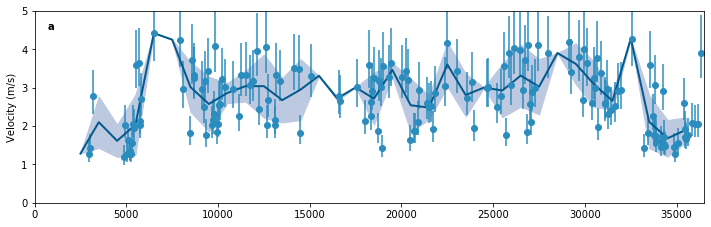

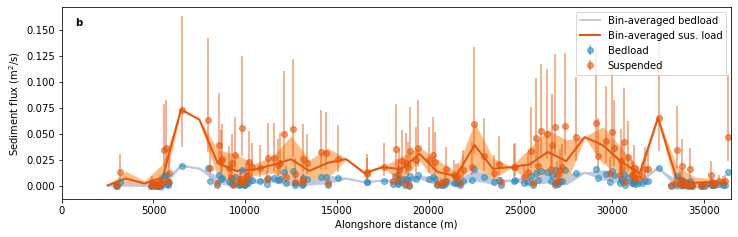

In [290]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print(bins)
bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = Vel
digitized = np.digitize(ychan, bins)
bin_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std[0]=0.
bin_std[1]=0.
bin_std =np.array(bin_std)

print(np.shape(bin_mean), print(np.shape(bin_std)))

plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
# plt.plot(channel_ctr[ia],Vel,'.',markersize=12,color=blue5[3])
ax1.errorbar(channel_ctr[ia],Vel,yerr=[Vel-Vello, Velhi-Vel], fmt='o',color=blue5[3])
plt.plot(bin_ctr,bin_mean,'-',color=blue5[4],linewidth=2,label='Bin-averaged velocity')
ax1.fill_between(bin_ctr, (bin_mean+bin_std), (bin_mean-bin_std),color=blue5[1] )

plt.ylim((0, 5))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
#plt.legend()
plt.ylabel('Velocity (m/s)')
plt.xlim((0,36500))

data = qbvr
bin_mean_qb = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qb  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qb[0]=0.
bin_std_qb[1]=0.
bin_std_qb =np.array(bin_std_qb)

data = qsvr
bin_mean_qs = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std_qs  = [data[digitized == i].std() for i in range(1, len(bins))]
bin_std_qs[0]=0.
bin_std_qs[1]=0.
bin_std_qs =np.array(bin_std_qs)

plt.figure(figsize=(12,12))
ax2=plt.subplot(312)
# plt.plot(channel_ctr[ia],qbvr,'.',markersize=12,color=blue5[3],alpha=0.6,label='Bedload')
# plt.plot(channel_ctr[ia],qsvr,'.',markersize=12,color=cols[3],alpha=0.6,label='Suspended')
ax2.errorbar(channel_ctr[ia], qbvr, yerr=[qbvr-qbvrlo, qbvrhi-qbvr], fmt='o',color=blue5[3],alpha=0.6,label='Bedload')
ax2.errorbar(channel_ctr[ia], qsvr, yerr=[qsvr-qsvrlo, qsvrhi-qsvr], fmt='o',color=cols[3],alpha=0.6,label='Suspended')
ax2.plot(bin_ctr,bin_mean_qb,'-',color=blue5[2],linewidth=2,label='Bin-averaged bedload')
ax2.fill_between(bin_ctr, (bin_mean_qb+bin_std_qb), (bin_mean_qb-bin_std_qb),color=blue5[1] )

ax2.plot(bin_ctr,bin_mean_qs,'-',color=cols[3],linewidth=2,label='Bin-averaged sus. load')
ax2.fill_between(bin_ctr, (bin_mean_qs+bin_std_qs), (bin_mean_qs-bin_std_qs),color=cols[1] )


plt.legend()
#plt.ylim((0, 5))
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
plt.ylabel('Sediment flux (m$^2$/s)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')

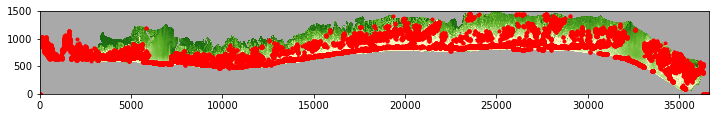

In [19]:
plt.figure(figsize=(12,7))
ax1=plt.subplot(411)
ax1.pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax1.plot(y,dmax[0,:],'.r')
plt.savefig('dune_crest_testmix.png',bbox_inches='tight', format='png',dpi=200)

NameError: name 'zmax_s0' is not defined

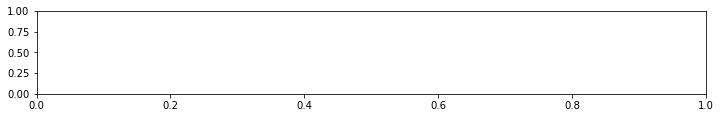

In [20]:
plt.figure(figsize=(12,7))
plt.plot(y[ss:se],dmax[0,ss:se],'.')
#plt.plot(y[ss:se],dmax[0,ss:se],'.')
plt.ylabel('Cross-shore dist. (m)')

ax2=plt.subplot(412)
plt.plot(y[ss:se],zmax_s0[ss:se],'.')
plt.plot(y[ss:se],zmax_s1[ss:se],'.')
plt.ylabel('Crest elev. (m)')

ax3=plt.subplot(413)
plt.plot(y[ss:se],zdiff[ss:se],'-')
plt.ylabel('Elev. Change (m)')

chana = np.cumsum(-zdiff[ss:se])
ax3=plt.subplot(414)
plt.plot(y[ss:se],chana)

In [ ]:
plt.boxplot(channel_width)
plt.ylim( (0,100) )

In [ ]:
%run -i CoreBx_funcs
s = stat_summary(channel_width,iprint=True)

In [ ]:
for sn, seg in enumerate(segs):
    ss = seg
    se = ss+sl
    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')

    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_s0[ss:se],'.')
    plt.plot(y[ss:se],zmax_s1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiff[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiff[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)

    try:
        print('Seg. {} total channel area m^2/m: {:.2f}'.format(sn, chana[-1]/sl) )
    except:
        pass

    plt.figure(figsize=(12,7))
    ax1=plt.subplot(411)
    plt.plot(y[ss:se],dmax[0,ss:se],'.')
    #plt.plot(y[ss:se],dmax[0,ss:se],'.')
    plt.ylabel('Cross-shore dist. (m)')
    
    ax2=plt.subplot(412)
    plt.plot(y[ss:se],zmax_0[ss:se],'.')
    plt.plot(y[ss:se],zmax_1[ss:se],'.')
    plt.ylabel('Crest elev. (m)')

    ax3=plt.subplot(413)
    plt.plot(y[ss:se],zdiffu[ss:se],'-')
    plt.ylabel('Elev. Change (m)')

    chana = np.cumsum(-zdiffu[ss:se])
    ax3=plt.subplot(414)
    plt.plot(y[ss:se],chana)
    plt.ylabel('Cumulative Area (m^2)')

In [ ]:
diffmap = np.squeeze(np.diff(dsaa,axis=0))
diffmap_tot = np.squeeze( dsaa[-1,:,:]-dsaa[0,:,:])
print(np.shape(diffmap),file=sfile)
print("Stats for diffmap:",file=sfile)
for i in range(0,nmaps-1):
    print("\n2d stats for diffmap {} minus {}".format(dates[i+1],dates[i]),file=sfile)
    map_stats2d(np.squeeze(diffmap[i,:,:]),sfile)
print("\nStats for last minus first:",file=sfile)
map_stats2d(diffmap_tot, sfile)


title_str = '{0:s}'.format(r['name'].capitalize())  

xs_start = 0
xs_end = r['xs_end']
dxdy = r['dxdy']
xs_len = (xs_end-xs_start)
print('\nxs_len = ',xs_len,' cross-shore length: ',ncross*dxdy,file=sfile)

# calculate dhi
dhi = np.nanmax( dsaa[:,0:r['d_end'],:],axis=1)
print("Shape of dhi: ",np.shape(dhi),file=sfile)

mean_dhi = np.nanmean(dhi,1)
std_dhi = np.nanstd(dhi,1)
print("Mean dhi: ",mean_dhi,file=sfile)
print("Mean and std of dhi: {} {} (m)".format(mean_dhi, std_dhi),file=sfile)
sfile.close()

In [ ]:
# open the log file in append mode
sfile = open(statsfn, "a+")
# calculate centroid of each transect
print('Calculating centroids')

# calculate volumes    
# volumes for each transect in beach and overwash terrace (nmaps, nalong)
v = np.squeeze(np.nansum(dsaa[:,xs_start:xs_end,:]-MHHW,axis=1))

# volumes for each transect across entire cell (nmaps, nalong)
vall = np.squeeze(np.nansum(dsaa[:,:,:]-MHHW,axis=1))

# respective volume differences (nmaps-1, nalong)
vdiff = np.squeeze(np.diff(v,axis=0))
vdiffall = np.squeeze(np.diff(vall,axis=0))

print("Shape of v: ",np.shape(v),file=sfile)
print("Shape of vdiff: ",np.shape(vdiff),file=sfile)

# average transect volume for overwash terrace (nmaps)
m = np.mean(v,1)
# average volume change for overwash terrace (nmaps-1)
mean_dv = np.sum(vdiff,1)/(ncross*dxdy)
print("Average transect volume for ow terrace m: ",m,file=sfile)
print("Average volume change for ow terrace mean_dv",mean_dv,file=sfile)

# update sum over entire island
vsum = vsum+np.nansum(v,1)
vsumall = vsumall+np.nansum(vall,1)
vchange = vchange+np.sum(vdiff,1)
vchangeall = vchangeall+np.sum(vdiffall,1)

island_length = island_length+r['xlen']


# calculate elevations
mean_elev_xs_len = np.nanmean(np.nanmean(dsaa[:,0:r['xs_end'],:],1),1)
mean_elev_all = np.nanmean(np.nanmean(dsaa,1),1)
print("Mean elevation in overwash terrace (m):",mean_elev_xs_len,file=sfile )
print("Mean elevation in across entire island (m):",mean_elev_all,file=sfile )

pc = 100*np.nanmean(vdiff)/np.mean(v)
pcall = 100*np.nanmean(vdiffall)/np.mean(vall)

print("Pct volume change in overwash terrace m:",pc,"%",file=sfile)
print("Pct volume change in across entire island m:",pcall,"%",file=sfile)
sfile.close()

In [ ]:
##############################################################################
# Elevation plots
title_str = '{0:s} Dune Crest Elevation and Barrier Volume'.format(r['name'].capitalize())
plt.figure(figsize=(12,7))
ax1=plt.subplot(211)
plt.plot(dhi[0,:],color='dimgray',linewidth=3,label=dates[0])
plt.plot(dhi[1,:],color='tab:red',linewidth=2,label=dates[1])
plt.plot(dhi[2,:],color='tab:blue',linewidth=2,label=dates[2])
plt.plot(dhi[3,:],color='tab:orange',linewidth=2,label=dates[3])

plt.legend(loc='upper right')
ax1.xaxis.set_ticklabels([])
ax1.set_ylim(0,7.5)
plt.ylabel('Dune Crest Elevation (m)')
plt.text(0,.85*7.5,"a) Crest Elevation")
plt.title(title_str)

# Volume plot
ax2=plt.subplot(212)
plt.plot([0, nalong*dxdy],[m[0],m[0]],'--',color='dimgray',linewidth=1)
plt.plot([0, nalong*dxdy],[m[1],m[1]],'--',color='tab:red',linewidth=1)
plt.plot([0, nalong*dxdy],[m[2],m[2]],'--',color='tab:blue',linewidth=1)
plt.plot([0, nalong*dxdy],[m[3],m[3]],'--',color='tab:orange',linewidth=1)
lb = []
for i in range(0,4):
    lb.append("{0} {1:4.0f} m$^3$".format(dates[i],m[i]))
plt.plot(v[0,:],label=lb[0],color='dimgray',linewidth=3)
plt.plot(v[1,:],label=lb[1],color='tab:red',linewidth=2)
plt.plot(v[2,:],label=lb[2],color='tab:blue',linewidth=2)
plt.plot(v[3,:],label=lb[3],color='tab:orange',linewidth=2)
ax2.set_ylim(0,950)
plt.xlabel(r'Alongshore Distance (m)')
plt.ylabel(r'Volume (m$^3$/m)')
plt.legend(loc='upper right')
title_str = 'b) Volumes'

plt.text(0,.85*950,title_str)
fig_name = "{}_{}_elevation_volume.svg".format(r['name'],holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')


In [ ]:
##############################################################################
#  Plot map views
dcmap=plt.cm.seismic
dcmap.set_bad(color='darkgray')
# text locations
tx = 0.025*r['xlen']
ty = 0.9*r['ylen']
print("tx, ty:",tx,ty)

fig, ax = plt.subplots(ncols=2, nrows=4, figsize=(9,9), constrained_layout=True)
ax[0,0].pcolormesh(dsaa[0,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[1,0].pcolormesh(dsaa[1,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[2,0].pcolormesh(dsaa[2,:,:],cmap=tcmap,vmin=0,vmax=6)
ax[3,0].pcolormesh(dsaa[3,:,:],cmap=tcmap,vmin=0,vmax=6)

ax[0,0].text(tx, ty,'a) {}'.format(dates[0]),c='lightgray')
ax[1,0].text(tx, ty,'b) {}'.format(dates[1]),c='lightgray')
ax[2,0].text(tx, ty,'c) {}'.format(dates[2]),c='lightgray')
ax[3,0].text(tx, ty,'d) {}'.format(dates[3]),c='lightgray')

ax[0,1].text(tx, ty,'e) {} minus {}'.format(dates[1],dates[0]))
ax[1,1].text(tx, ty,'f) {} minus {}'.format(dates[2],dates[1]))
ax[2,1].text(tx, ty,'g) {} minus {}'.format(dates[3],dates[2]))
ax[3,1].text(tx, ty,'h) {} minus {}'.format(dates[3],dates[0]))

ax[0,0].set_ylabel('Cross-shore Distance (m)')
ax[1,0].set_ylabel('Cross-shore Distance (m)')
ax[2,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_ylabel('Cross-shore Distance (m)')
ax[3,0].set_xlabel('Alongshore Distance (m)')

ax[0,1].pcolormesh(diffmap[0,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[0,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[1,1].pcolormesh(diffmap[1,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[1,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[2,1].pcolormesh(diffmap[2,:,:],cmap=dcmap,vmin=-3,vmax=3)
ax[2,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')
ax[3,1].pcolormesh(diffmap_tot,cmap=dcmap,vmin=-3,vmax=3)
ax[3,1].plot((0,nalong),(xs_end,xs_end),'--',c='darkgray')

ax[3,1].set_xlabel('Alongshore Distance (m)')

ax[0,0].xaxis.set_ticklabels([])
ax[1,0].xaxis.set_ticklabels([])
ax[2,0].xaxis.set_ticklabels([])
ax[0,1].xaxis.set_ticklabels([])
ax[1,1].xaxis.set_ticklabels([])
ax[2,1].xaxis.set_ticklabels([])
ax[0,1].yaxis.set_ticklabels([])
ax[1,1].yaxis.set_ticklabels([])
ax[2,1].yaxis.set_ticklabels([])
ax[3,1].yaxis.set_ticklabels([])

title_str = '{0:s} Elevation and Difference Maps'.format(r['name'].capitalize())
ax[0,0].set_title(title_str)

fig_name = "{}_{}_maps.png".format(r['name'],holes[ihole])
plt.savefig(fig_name, bbox_inches='tight', dpi = 300)

# open the log file in append mode
sfile = open(statsfn, "a+")
print('\nOverall statistics for hole filling with {}')
print('Vsum',vsum,' m3',file=sfile)
print('Volume change:',vchange, ' m3',file=sfile)
print('Volume change %',100*vchange/vsum[0], file=sfile)
print('Vsumall',vsumall,' m3',file=sfile)
print('Volume change all:',vchangeall, ' m3',file=sfile)
print('Volume change all %',100*vchangeall/vsumall[0],file=sfile)
print('Island length:',island_length,' m',file=sfile)
print('Mean volume change: ',vchange/island_length,' m3/m',file=sfile)

sfile.close()

# Plot total volumes
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%d %b %Y"))
dt = np.array(dtl)

fig, ax = plt.subplots(1)
fig.autofmt_xdate()
plt.plot(dt,vsumall/1e6,label="Entire island")
plt.plot(dt,vsum/1e6,label="Beach and overwash")
plt.ylabel('Million m$^3$')
plt.xticks(dt)
plt.grid()
plt.legend()
plt.title('Island Volume')
fig_name = 'island_volume_{}.svg'.format(holes[ihole])
plt.savefig(fig_name,bbox_inches='tight', format='svg')